## Aprendizaje Automático II - Miguel Angel Ruiz Ortiz

Considere el valor histórico (por hora) de cripto-monedas (al menos 7 series, incluyendo el bitcoin) obtenga N series de al menos una longitud de T = 100. Luego entrene un modelo para dadas las series S[:T-t] prediga la parte final de cada serie S[T-t:]. Un valor típico es t=5. Implementar un modelo Seq2Seq con atención, usando refuerzo del profesor (teacher forcing).

## Librerías

In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
devices = tf.config.list_physical_devices()
print("Devices: ", devices)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


## Datos

### Petición de datos con Yahoo Finance

Pedimos con la librería ``yfinance`` para descargar el precio (con respecto al dólar) de una criptomoneda dada a través de la API de Yahoo Finance. Las criptomonedas que se consideraron son:
- Bitcoin (BTC), 
- Ethereum (ETH), 
- Binance Coin (BNB), 
- XRP (Ripple), 
- Cardano (ADA), 
- Solana (SOL), 
- Dogecoin (DOGE)

Los precios son cada hora, durante 1 año. Abarcan hasta el día de la petición de los datos.

In [3]:
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'SOL-USD', 'DOGE-USD']

period = "1y"
interval = "1h" 

# Dictionary { crypto: prices }
crypto_data = {}

# Fetch data for each crypto. Download hourly-level data
for crypto in cryptos:
    crypto_data[crypto] = yf.download(crypto, period=period, interval=interval)
    print(f"Descarga de datos para {crypto}: {crypto_data[crypto].shape[0]} datos - desde {crypto_data[crypto].index[0]} a {crypto_data[crypto].index[-1]}")

[*********************100%***********************]  1 of 1 completed


Descarga de datos para BTC-USD: 8783 datos - desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


[*********************100%***********************]  1 of 1 completed


Descarga de datos para ETH-USD: 8782 datos - desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


[*********************100%***********************]  1 of 1 completed


Descarga de datos para BNB-USD: 8783 datos - desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


[*********************100%***********************]  1 of 1 completed


Descarga de datos para XRP-USD: 8783 datos - desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


[*********************100%***********************]  1 of 1 completed


Descarga de datos para ADA-USD: 8783 datos - desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


[*********************100%***********************]  1 of 1 completed


Descarga de datos para SOL-USD: 8782 datos - desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


[*********************100%***********************]  1 of 1 completed

Descarga de datos para DOGE-USD: 8776 datos - desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


Por cada criptomoneda, la librería nos da diferentes datos (percio de apertura, cierre, etc.). Aquí se trabajó sólo con los precios de cierre.

In [4]:
# Bitcoin data
crypto_data['BTC-USD'].head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-18 03:00:00+00:00,26671.333984,26682.650391,26596.775391,26659.097656,26659.097656,0
2023-09-18 04:00:00+00:00,26670.859375,26686.320312,26583.496094,26624.929688,26624.929688,124461568
2023-09-18 05:00:00+00:00,26630.630859,26675.908203,26616.996094,26668.037109,26668.037109,48612864
2023-09-18 06:00:00+00:00,26664.986328,26701.064453,26653.375000,26672.318359,26672.318359,60485120
2023-09-18 07:00:00+00:00,26637.781250,26770.292969,26637.781250,26712.169922,26712.169922,295854592


In [5]:
# we consider close prices
crypto_data = {crypto: crypto_data[crypto]["Close"] for crypto in cryptos}

### Detección y llenado de valores faltantes

Por falta de algunos datos, las series de tiempo a veces no empiezan y terminan igual. De manera que se calculó el intervalo de tiempo presente en todas las series de tiempo.

Nota: Esto depende del día en que se pidan los datos. Es decir, a veces todas las series de tiempo sí empiezan y terminan igual, pero a veces no, dependiendo del día en que se pidan los datos. En la última ejecución no fue necesario.

In [6]:
start_timestamp = max([crypto_data[crypto].index[0] for crypto in cryptos]) 
end_timestamp = min([crypto_data[crypto].index[-1] for crypto in cryptos])
time_index = pd.date_range(start=start_timestamp, end=end_timestamp, freq='1h') # hours from start_timestamp to end_timestamp
print("Intervalo de tiempo de los datos: desde", start_timestamp, "a", end_timestamp)

Intervalo de tiempo de los datos: desde 2023-09-18 03:00:00+00:00 a 2024-09-18 02:00:00+00:00


Tiempos faltante en cada serie de tiempo:

In [7]:
all_times_set = set(time_index)
for crypto in cryptos:
    missing_times = all_times_set.difference(crypto_data[crypto].index)
    print(f"Tiempos faltantes para crypto {crypto}: {len(missing_times)}")
    print(missing_times)
    print("\n")

Tiempos faltantes para crypto BTC-USD: 1
{Timestamp('2023-10-24 15:00:00+0000', tz='UTC')}


Tiempos faltantes para crypto ETH-USD: 2
{Timestamp('2023-12-13 14:00:00+0000', tz='UTC'), Timestamp('2023-10-24 15:00:00+0000', tz='UTC')}


Tiempos faltantes para crypto BNB-USD: 1
{Timestamp('2023-10-24 15:00:00+0000', tz='UTC')}


Tiempos faltantes para crypto XRP-USD: 1
{Timestamp('2023-10-24 15:00:00+0000', tz='UTC')}


Tiempos faltantes para crypto ADA-USD: 1
{Timestamp('2023-10-24 15:00:00+0000', tz='UTC')}


Tiempos faltantes para crypto SOL-USD: 2
{Timestamp('2023-12-13 14:00:00+0000', tz='UTC'), Timestamp('2023-10-24 15:00:00+0000', tz='UTC')}


Tiempos faltantes para crypto DOGE-USD: 8
{Timestamp('2023-11-19 01:00:00+0000', tz='UTC'), Timestamp('2023-11-19 00:00:00+0000', tz='UTC'), Timestamp('2023-10-24 15:00:00+0000', tz='UTC'), Timestamp('2023-11-18 23:00:00+0000', tz='UTC'), Timestamp('2023-11-18 21:00:00+0000', tz='UTC'), Timestamp('2023-11-19 02:00:00+0000', tz='UTC'), Timesta

Utilizamos la estrategia de rellenar los valores faltantes hacia adelante ("forward fill"), i.e., con el dato disponible anterior.

In [8]:
for crypto in cryptos:
    crypto_data[crypto] = crypto_data[crypto].reindex(time_index, method='ffill')
    print(f"Longitud de serie de tiempo {crypto}: {crypto_data[crypto].size}")

Longitud de serie de tiempo BTC-USD: 8784
Longitud de serie de tiempo ETH-USD: 8784
Longitud de serie de tiempo BNB-USD: 8784
Longitud de serie de tiempo XRP-USD: 8784
Longitud de serie de tiempo ADA-USD: 8784
Longitud de serie de tiempo SOL-USD: 8784
Longitud de serie de tiempo DOGE-USD: 8784


In [9]:
dataset_df = pd.DataFrame(crypto_data)
data = dataset_df.to_numpy()
dataset_df.head()

,BTC-USD,ETH-USD,BNB-USD,XRP-USD,ADA-USD,SOL-USD,DOGE-USD
2023-09-18 03:00:00+00:00,26659.097656,1629.741455,217.830093,0.497337,0.249284,19.204222,0.061809
2023-09-18 04:00:00+00:00,26624.929688,1630.428589,217.081177,0.497421,0.249350,19.059607,0.061723
2023-09-18 05:00:00+00:00,26668.037109,1631.512207,217.270325,0.495707,0.249015,19.137966,0.061782
2023-09-18 06:00:00+00:00,26672.318359,1630.511108,217.335846,0.493208,0.248663,19.120892,0.061766
2023-09-18 07:00:00+00:00,26712.169922,1634.266113,216.986725,0.491757,0.248552,19.118294,0.061820


### Creación de datasets de entrenamiento, validación y prueba

Un elemento de nuestro dataset para el modelo es una secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ donde $x_j$ es un vector con los precios de las 7 criptomonedas al tiempo $j$. Dada dicha secuencia, el modelo va a predecir los siguientes $m$ datos, es decir, la secuencia $(x_{t+\tau}, ..., x_{t+\tau+m-1})$. Para poder aplicar el forzamiento del maestro ("teacher forcing"), el decoder necesita la secuencia que va a predecir pero trasladada un paso en el tiempo hacia atrás, i.e., $(x_{t+\tau-1}, ..., x_{t+\tau+m-2})$. 

Para que el modelo no tenga "información del futuro", se usarán los primeros ``n_train`` datos de cada serie para formar el conjunto de entrenamiento, los siguientes ``n_val`` para el conjunto de validación, y los últimos ``n_test`` para el conjunto de prueba. Es decir, los tiempo en el dataset de entrenamiento son antes que los tiempos en el dataset de validación, y a su vez estos tiempos son antes de los tiempos en el dataset de prueba.

In [10]:
total_data = len(dataset_df)
n_train = int(total_data*0.60)
n_val = int(total_data*0.20)
n_test = total_data - n_train - n_val 

print(f"Total de datos: {total_data}")
print(f"- Entrenamiento: {n_train} datos")
print(f"- Validación: {n_val} datos")
print(f"- Prueba: {n_test} datos")

train_data = data[:n_train]
val_data = data[n_train: n_train+n_val]
test_data = data[-n_test:]

Total de datos: 8784
- Entrenamiento: 5270 datos
- Validación: 1756 datos
- Prueba: 1758 datos


In [11]:
T = 100 
m = 5
tau = T - m

Para evitar un sobreajuste, no le damos todas las posibles secuencias $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ del conjunto de entrenamiento, si no sólo un 85% de ellas de manera aleatoria.

In [12]:
np.random.seed(0)

train_indices = np.random.choice(n_train - T, int(0.85 * (n_train - T)), replace=False) # time for index i corresponds to time_index[i]

X_train_raw = np.array([train_data[i : i + T] for i in train_indices])
X_train, y_train, decoder_input_train = X_train_raw[:, : T - m, :], X_train_raw[:, -m:, :], X_train_raw[:, -m-1:-1, :]

X_val_raw = np.array([val_data[i : i + T] for i in range(n_val-T)])
X_val, y_val, decoder_input_val = X_val_raw[:, : T - m, :], X_val_raw[:, -m:, :], X_val_raw[:, -m-1:-1, :]

X_test_raw = np.array([test_data[i : i + T] for i in range(n_test-T)])
X_test, y_test, decoder_input_test = X_test_raw[:, : T - m, :], X_test_raw[:, -m:, :], X_test_raw[:, -m-1:-1, :]

In [13]:
def index2timestamp(i: int, dataset_type: str) -> pd.Timestamp:
    # auxiliar function to know the timestamp t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1}), given the index i in the corresponding dataset ("train", "val", "test")
    if dataset_type == "train":
        return time_index[i]
    if dataset_type == "val":
        return time_index[n_train + i]
    if dataset_type == "test":
        return time_index[-n_test + i]

### Preprocesamiento: Normalización local

Dado que las series de tiempo financieras tienen una volatilidad (varianza) cambiante a lo largo del tiempo, no conviene utilizar el proceso de normalización estándar, i.e., restar varianza y luego dividir entre desviación estándar usando todos los datos de cada serie de tiempo. En vez de eso, utilizamos una normalización local en la que a cada secuencia se le calcula su propia media y desviación estándar para normalizar sólo esa secuencia por cada criptomoneda.

In [14]:
# compute vector of means and standard deviations, for each sequence and for each crypto.

means_train = X_train.mean(axis=1) # vector mu of means for each sequence, i.e., mu[i] is the vector of means for sequence i, which has the mean for each crypto in that sequence
stds_train = X_train.std(axis=1) # vector of standard deviations for each sequence

means_val = X_val.mean(axis=1)
stds_val = X_val.std(axis=1)

means_test = X_test.mean(axis=1)
stds_test = X_test.std(axis=1)

In [15]:
# training data preprocessing
for i in range(X_train.shape[0]):
    X_train[i] = (X_train[i] - means_train[i])/stds_train[i]
    y_train[i] = (y_train[i] - means_train[i])/stds_train[i]

# validation data preprocessing
for i in range(X_val.shape[0]):
    X_val[i] = (X_val[i] - means_val[i])/stds_val[i]
    y_val[i] = (y_val[i] - means_val[i])/stds_val[i]
    
# testing data preprocessing
for i in range(X_test.shape[0]):
    X_test[i] = (X_test[i] - means_test[i])/stds_test[i]
    y_test[i] = (y_test[i] - means_test[i])/stds_test[i]

In [16]:
def normalized_2_raw(data_norm: np.ndarray, means: np.ndarray, stds: np.ndarray) -> np.ndarray:
    # function to go back from local normalization to raw prices
    
    data_raw = np.zeros(data_norm.shape)

    for i in range(data_norm.shape[0]):
        data_raw[i] = stds[i]*data_norm[i] + means[i]
        
    return data_raw

## Seq2Seq

Primero implementamos el modelo Seq2Seq usual, para comparar después con el Seq2Seq con atención.

In [17]:
class Seq2Seq:
    def __init__(self, latent_dim, dim_vectors):
        self.dim_vectors = dim_vectors
        
        # encoder
        encoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        encoder_o, encoder_h, encoder_c = keras.layers.LSTM(units = latent_dim, return_state = True)(encoder_inputs)
        encoder_states = [encoder_h, encoder_c]

        # decoder
        decoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        decoder_lstm = keras.layers.LSTM(units = latent_dim, return_sequences=True, return_state=True)
        decoder_o, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = keras.layers.Dense(dim_vectors)
        decoder_outputs = decoder_dense(decoder_o)

        # Define the full model that will be trained with teacher forcing
        self.model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
        
        # encoder for inference
        self.encoder_model = keras.models.Model(encoder_inputs, encoder_states)

        # adapted decoder for inference, using one output decoder as the next input of it
        decoder_state_input_h = keras.layers.Input(shape=(latent_dim,))
        decoder_state_input_c = keras.layers.Input(shape=(latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        decoder_o, decoder_h, decoder_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_outputs = decoder_dense(decoder_o)

        self.decoder_model = keras.models.Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs, decoder_h, decoder_c]
            )
        
    def compile(self, optimizer, loss, metrics):
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )
        
    def fit(self, X_train, decoder_input_train, y_train, X_val, decoder_input_val, y_val, **kargs):
        self.model.fit(
            [X_train, decoder_input_train], y_train,
            validation_data=([X_val, decoder_input_val], y_val),
            **kargs
        )
        
    def predict(self, nsteps, X_test):
        state_h, state_c = self.encoder_model.predict(X_test)
        last_values = X_test[:, -1:, :]
        pred_test = np.zeros(shape=(X_test.shape[0], nsteps, self.dim_vectors))

        for i in range(nsteps):
            last_values, state_h, state_c = self.decoder_model.predict([last_values, state_h, state_c])
            pred_test[:, i, :] = last_values[:,0,:]
            
        return pred_test

### Entrenamiento

In [18]:
latent_dim = 512
dim_vectors = 7

seq2seq_model = Seq2Seq(latent_dim, dim_vectors)

seq2seq_model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.MeanAbsoluteError()])

seq2seq_model.fit(X_train, decoder_input_train, y_train, X_val, decoder_input_val, y_val, batch_size=64, epochs=12)

2024-09-17 20:59:25.466640: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-17 20:59:25.466678: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-17 20:59:25.466689: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-17 20:59:25.466705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-17 20:59:25.466717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/12


2024-09-17 20:59:26.121547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1.2839 - mean_absolute_error: 0.8289 - val_loss: 0.3824 - val_mean_absolute_error: 0.4446
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.3938 - mean_absolute_error: 0.4286 - val_loss: 0.2892 - val_mean_absolute_error: 0.3636
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2561 - mean_absolute_error: 0.3315 - val_loss: 0.2080 - val_mean_absolute_error: 0.2927
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2015 - mean_absolute_error: 0.2842 - val_loss: 0.2834 - val_mean_absolute_error: 0.3689
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2553 - mean_absolute_error: 0.3376 - val_loss: 0.1962 - val_mean_absolute_error: 0.2835
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2007 - mean_absolute_error: 0.2820 - val_loss: 0.1860 - val_mean_absolute_error: 0.2788
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1871 - mean_absolute_error: 0.2705 - val_loss: 0.1783 - 

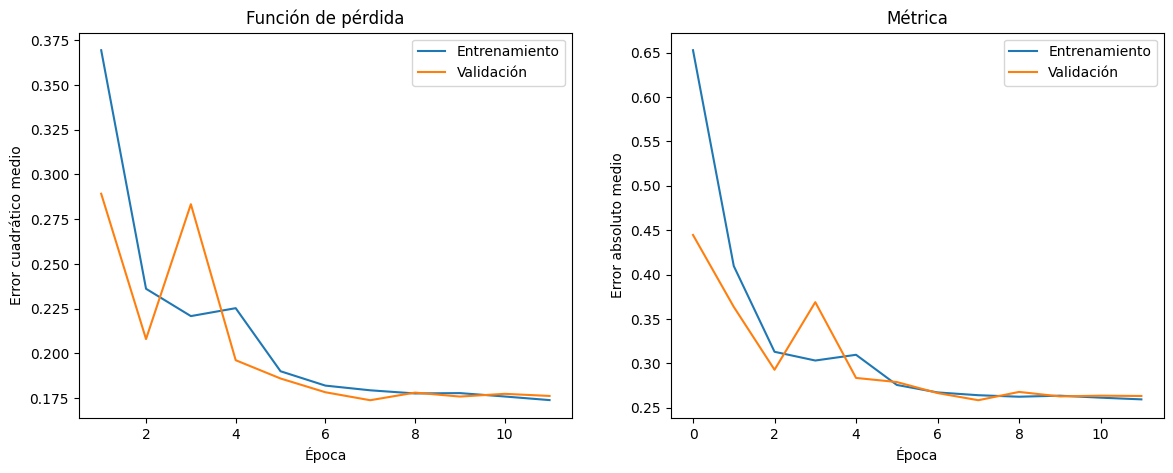

In [19]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 12), seq2seq_model.model.history.history["loss"][1:], label="Entrenamiento")
plt.plot(range(1, 12), seq2seq_model.model.history.history["val_loss"][1:], label="Validación")
plt.title("Función de pérdida")
plt.xlabel("Época")
plt.ylabel("Error cuadrático medio")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(seq2seq_model.model.history.history["mean_absolute_error"], label="Entrenamiento")
plt.plot(seq2seq_model.model.history.history["val_mean_absolute_error"], label="Validación")
plt.title("Métrica")
plt.xlabel("Época")
plt.ylabel("Error absoluto medio")
plt.legend()

plt.show()

### Inferencia

Predicciones sobre el conjunto de prueba

In [20]:
pred_test = seq2seq_model.predict(nsteps=m, X_test=X_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Error absoluto medio obtenido en cada serie de tiempo. Primero en la misma escala de la normalización:

In [21]:
# flatten predictions and targets
pred_test_flat = pred_test.reshape(-1, dim_vectors)
y_test_flat = y_test.reshape(-1, dim_vectors)

mae = mean_absolute_error(y_test_flat, pred_test_flat, multioutput='raw_values')

print("Errores absolutos medios en la escala normalizada:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae[i])

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.4733038420747696
ETH-USD : 0.46973786003174256
BNB-USD : 0.44662280272648913
XRP-USD : 0.4747470803663563
ADA-USD : 0.43816097764040046
SOL-USD : 0.48532487510304884
DOGE-USD : 0.45203726994876103


Ahora en la escala de precios:

In [22]:
pred_prices = normalized_2_raw(pred_test, means_test, stds_test)
y_prices_raw = X_test_raw[:, -m:, :]

pred_prices_flat = pred_prices.reshape(-1, dim_vectors)
y_prices_flat = y_prices_raw.reshape(-1, dim_vectors)

mae_seq2seq = mean_absolute_error(y_prices_flat, pred_prices_flat, multioutput='raw_values')

print("Errores absolutos medios en la escala de los precios:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_seq2seq[i])

Errores absolutos medios en la escala de los precios:
BTC-USD : 61179.40495340996
ETH-USD : 2806.2617281870093
BNB-USD : 545.1101895729036
XRP-USD : 1.3070246932094194
ADA-USD : 1.3740529598919335
SOL-USD : 150.9288621901788
DOGE-USD : 1.2370247507619245


Vemos gráficamente las predicciones escogiendo aleatoriamente 4 tiempos $t$ para visualizar la secuencia real y la secuencia predicha, en una vecindad de dichos tiempos

In [23]:
np.random.seed(0)
rand_ind = np.random.choice(n_test-T, size=4, replace=False)

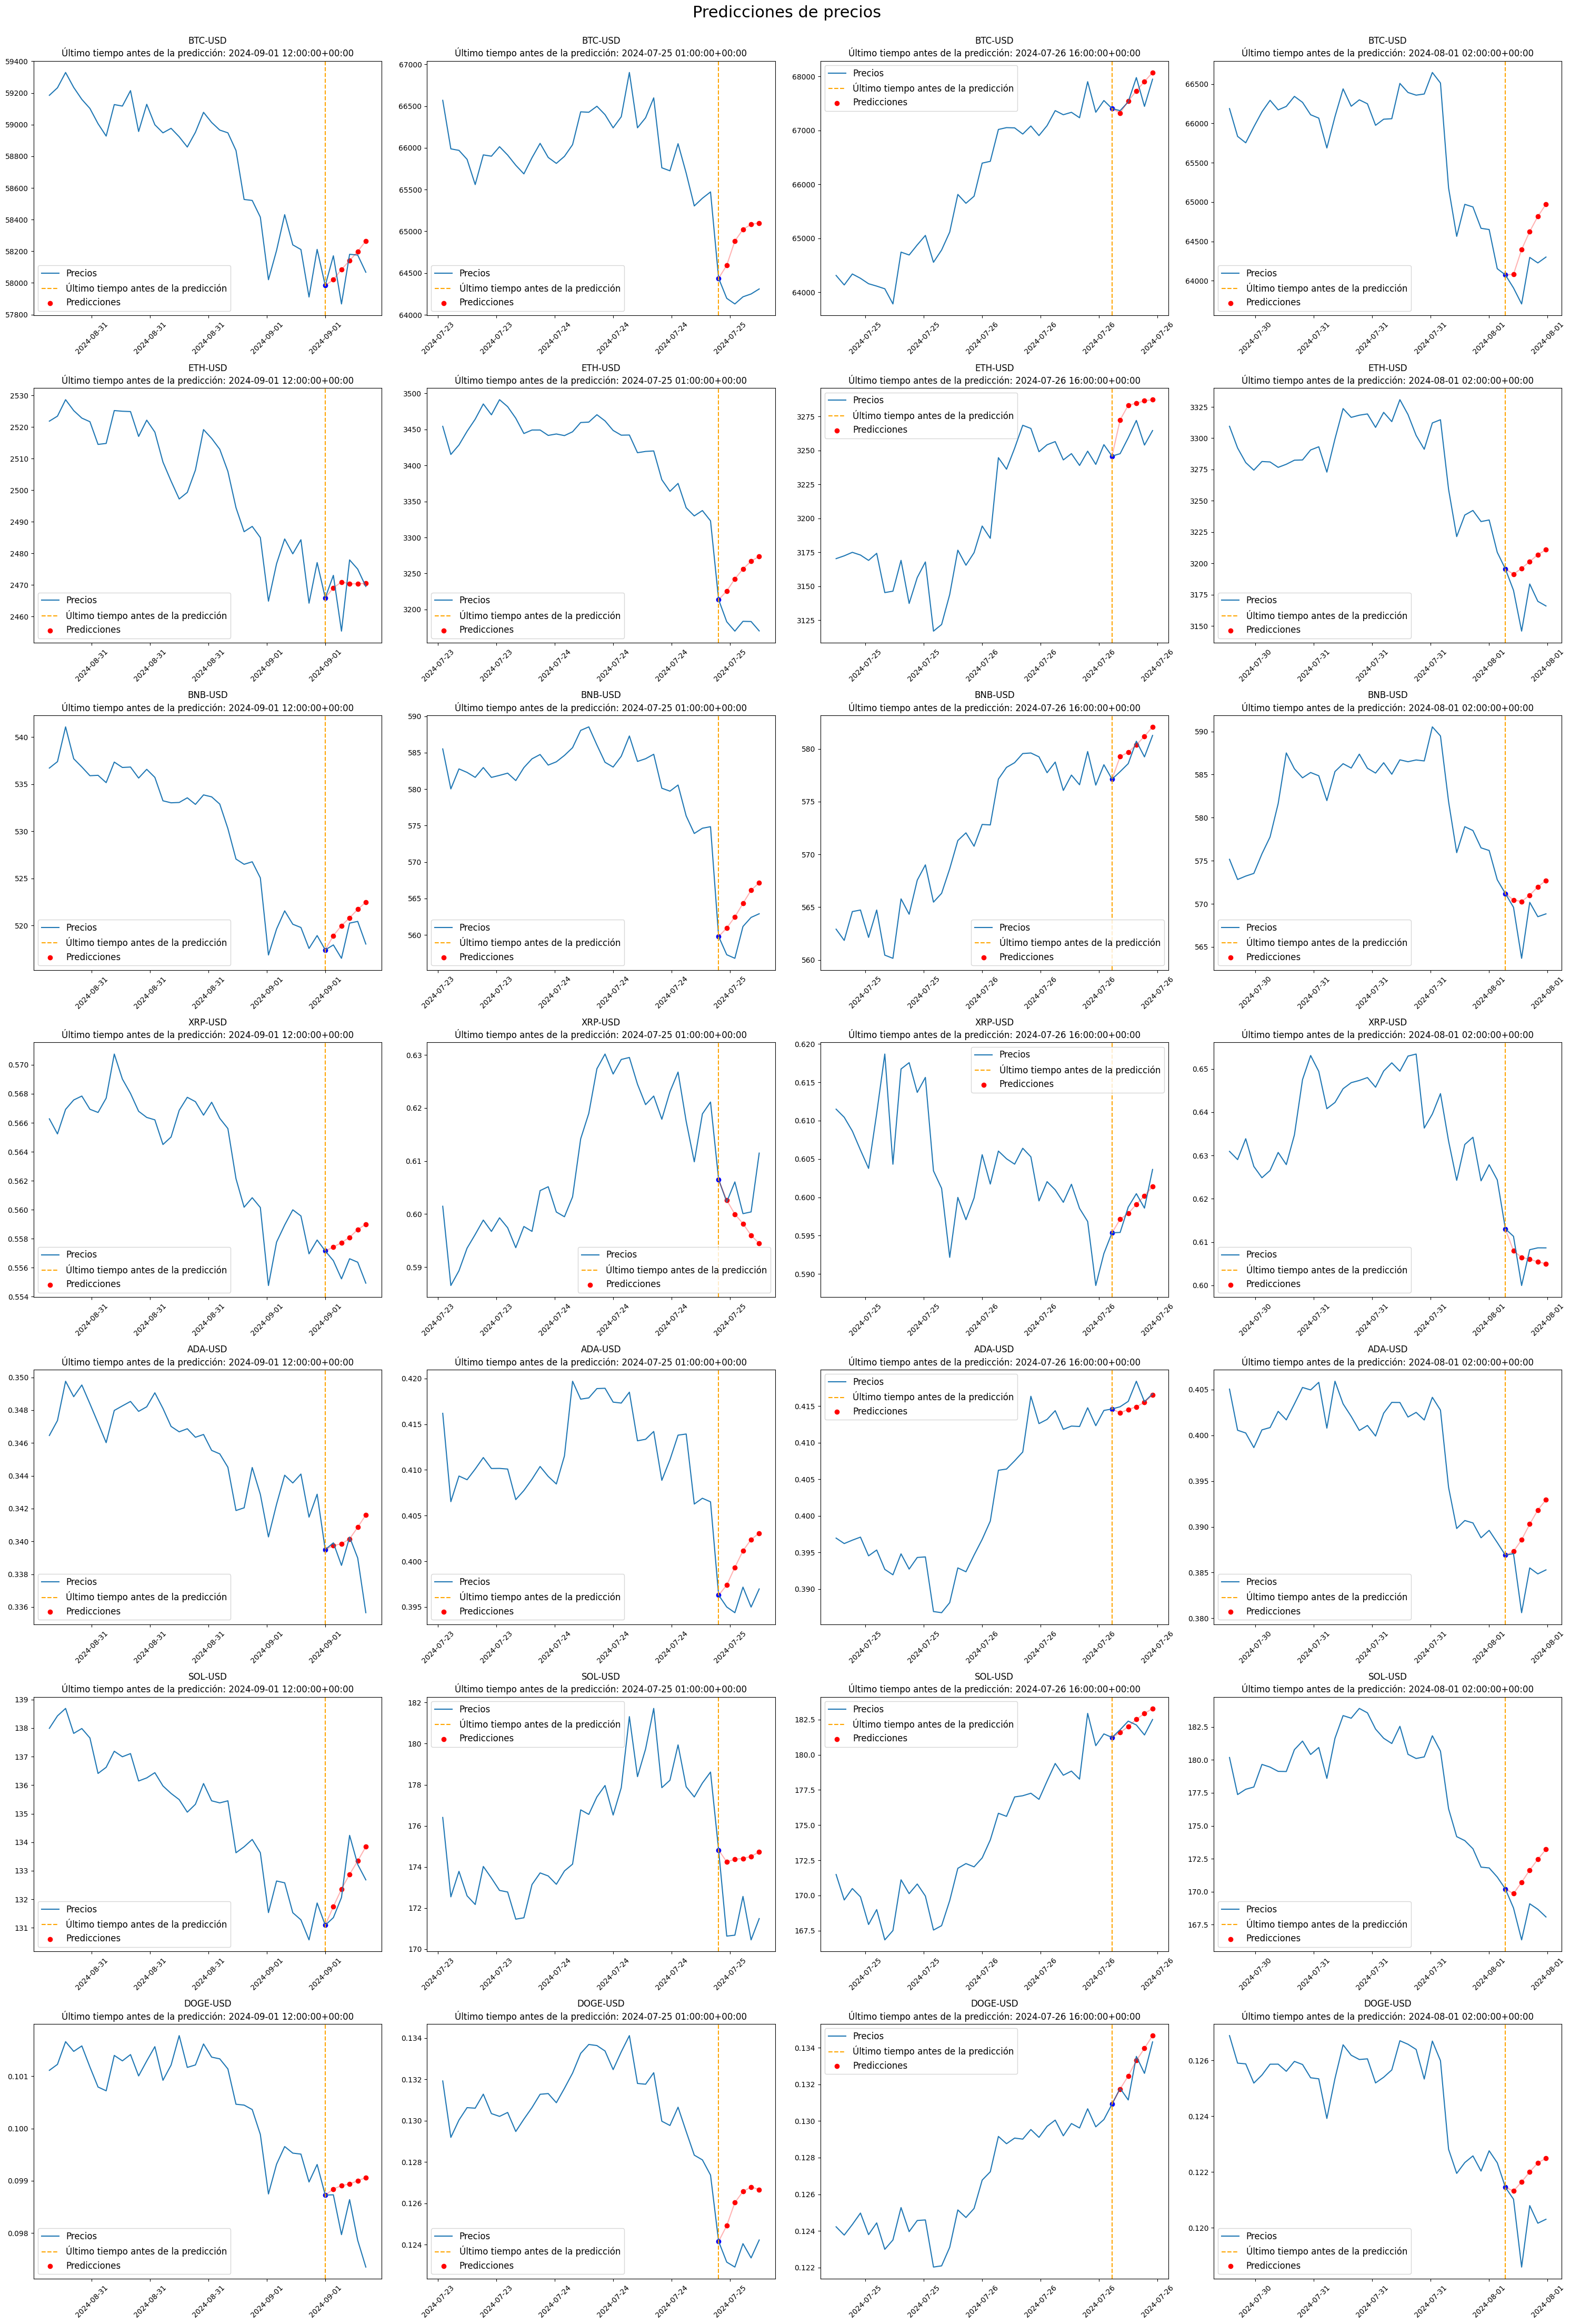

In [24]:
n_rows, n_cols = 7, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 45))

fig.suptitle("Predicciones de precios", fontsize=22)

window_size = 40

# Iterate over each subplot (i, j) to plot prices of i-th crypto and visually evaluate performance of prediction j
for j in range(n_cols):
    jth_time = index2timestamp(rand_ind[j], "test") # time t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1})
    jth_data = dataset_df.loc[
        jth_time + pd.Timedelta(hours=T-window_size) : jth_time + pd.Timedelta(hours=T-1)
    ] # from the window of size T starting at t, just consider the last window_size points
    
    pred_times = jth_data.index[-m:] # predicted times
    last_time = jth_data.index[-m-1] # last time t+\tau -1
    
    for i in range(n_rows):
        ith_crypto = cryptos[i]
        last_price = dataset_df.loc[last_time][ith_crypto]
        
        axes[i, j].plot(jth_data[ith_crypto], label="Precios")
        axes[i, j].plot([last_time]+[t for t in pred_times], [last_price]+[pt for pt in pred_prices[rand_ind[j], :, i]], color="r", alpha=0.3)
        axes[i, j].axvline(last_time, color='orange', linestyle='--', label='Último tiempo antes de la predicción')
        axes[i, j].scatter(pred_times, pred_prices[rand_ind[j], :, i], color="r", label="Predicciones")
        axes[i, j].scatter([last_time], [last_price], color="b")
        axes[i, j].set_title(f"{ith_crypto}\nÚltimo tiempo antes de la predicción: {last_time}", fontsize=12)
        axes[i, j].xaxis.set_major_locator(plt.MaxNLocator(7))
        axes[i, j].tick_params(axis="x", labelrotation=45)
        axes[i,j ].legend(fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Seq2Seq + Atención

Implementación del Seq2Seq con atención. Para esto se implementó la atención de Luong (atención multiplicativa) en la que el score entre un estado escondido del decoder $h_t$ y un estado escondido del encoder $\tilde{h}_s$ se obtiene como 
$$
h_t^T W \tilde{h}_s,
$$
donde $W$ es una matriz que se aprende. Esto se implementó a través de una capa densa con matriz de pesos $W^T$ que actua sobre los estados escondidos del decoder. De tal manera que si $Q$ y $K$ son las matrices con los estados escondidos del decoder y encoder, respectivamente, en sus renglones, entonces la matriz de scores queda como 
$$
QWK^T.
$$
Note que al pasar $K$ a través de la capa densa con matriz de pesos $W^T$, obtenemos $KW^T$.

In [25]:
class MultiplicativeAttention(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        
        # dense layer to compute multiplicative style scores
        self.score_dense = keras.layers.Dense(units, use_bias=False)

    def call(self, inputs):
        query, key = inputs # query are the hidden states of decoder, and key are the hidden states of encoder

        # Compute attention scores QxWxK^T
        scores = tf.matmul(query, self.score_dense(key), transpose_b=True)

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Compute context vector as weighted average of encoder's hidden states
        context = tf.matmul(attention_weights, key)

        return context, attention_weights
    
class Seq2SeqAttention:
    def __init__(self, latent_dim, dim_vectors):
        self.dim_vectors = dim_vectors
        
        # encoder
        encoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        encoder_o, encoder_h, encoder_c = keras.layers.LSTM(units = latent_dim, return_sequences=True, return_state = True)(encoder_inputs)
        encoder_states = [encoder_h, encoder_c]

        # decoder
        decoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        decoder_lstm = keras.layers.LSTM(units = latent_dim, return_sequences=True, return_state=True)
        decoder_o, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        
        attention_layer = MultiplicativeAttention(latent_dim)
        context, attention_weights = attention_layer([decoder_o, encoder_o])
        
        # Concatenate attention output and decoder LSTM output
        decoder_concat_input = keras.layers.Concatenate(axis=-1)([decoder_o, context])
        
        # last dense layer
        decoder_dense = keras.layers.Dense(dim_vectors)
        decoder_outputs = decoder_dense(decoder_concat_input)

        # Define the full model that will be trained with teacher forcing
        self.model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
        
        # encoder for inference
        self.encoder_model = keras.models.Model(encoder_inputs, [encoder_o] + encoder_states)

        # adapted decoder for inference, using one output decoder as the next input of it
        decoder_state_input_h = keras.layers.Input(shape=(latent_dim,))
        decoder_state_input_c = keras.layers.Input(shape=(latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        
        encoder_o_inf = keras.layers.Input(shape=(None, latent_dim))

        decoder_inf_o, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        context_inf, attention_weights_inf = attention_layer([decoder_inf_o, encoder_o_inf])
        decoder_inf_concat = keras.layers.Concatenate(axis=-1)([decoder_inf_o, context_inf])
        decoder_inf_outputs = decoder_dense(decoder_inf_concat)

        self.decoder_model = keras.models.Model(
            [decoder_inputs, encoder_o_inf] + decoder_states_inputs,
            [decoder_inf_outputs, state_h, state_c]
        )
        
    def compile(self, optimizer, loss, metrics):
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )
        
    def fit(self, X_train, decoder_input_train, y_train, X_val, decoder_input_val, y_val, **kargs):
        self.model.fit(
            [X_train, decoder_input_train], y_train,
            validation_data=([X_val, decoder_input_val], y_val),
            **kargs
        )
        
    def predict(self, nsteps, X_test):
        encoder_o, state_h, state_c = self.encoder_model.predict(X_test)
        last_values = X_test[:, -1:, :]
        pred_test = np.zeros(shape=(X_test.shape[0], nsteps, self.dim_vectors))

        for i in range(nsteps):
            last_values, state_h, state_c = self.decoder_model.predict([last_values, encoder_o, state_h, state_c])
            pred_test[:, i, :] = last_values[:,0,:]
            
        return pred_test

### Entrenamiento

In [26]:
latent_dim = 512
dim_vectors = 7

seq2seq_attention_model = Seq2SeqAttention(latent_dim, dim_vectors)

seq2seq_attention_model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.MeanAbsoluteError()])

seq2seq_attention_model.fit(X_train, decoder_input_train, y_train, X_val, decoder_input_val, y_val, batch_size=64, epochs=12)

Epoch 1/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 1.4731 - mean_absolute_error: 0.9007 - val_loss: 0.3358 - val_mean_absolute_error: 0.3981
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.3072 - mean_absolute_error: 0.3641 - val_loss: 0.2328 - val_mean_absolute_error: 0.3220
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2130 - mean_absolute_error: 0.2927 - val_loss: 0.1973 - val_mean_absolute_error: 0.2872
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1951 - mean_absolute_error: 0.2763 - val_loss: 0.1810 - val_mean_absolute_error: 0.2692
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1791 - mean_absolute_error: 0.2675 - val_loss: 0.1787 - val_mean_absolute_error: 0.2675
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1823 - mean_absolute_error: 0.2659 - val_loss: 0.1776 - val_mean_absolute_error: 0.2670
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1876 - mean_absolute_error: 0.2689 - val_loss

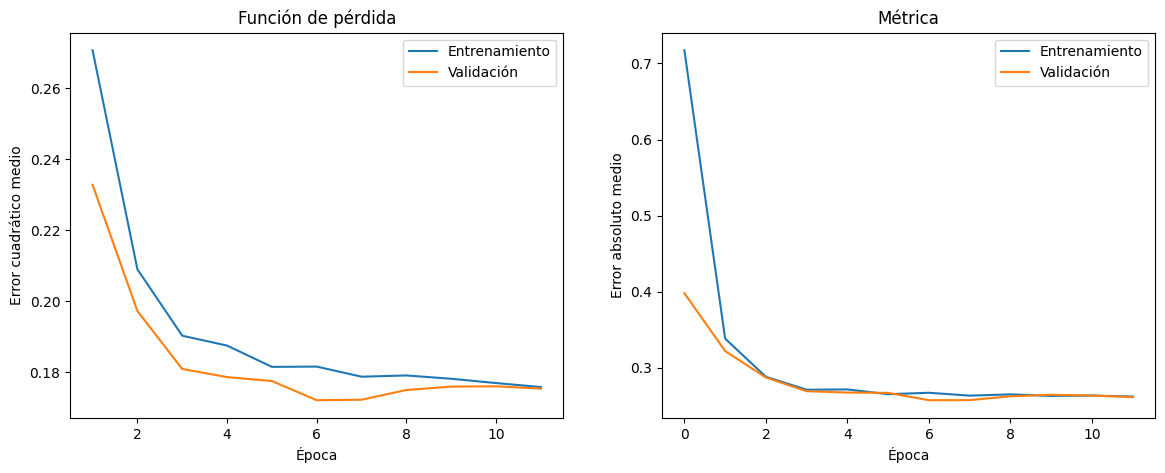

In [27]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 12), seq2seq_attention_model.model.history.history["loss"][1:], label="Entrenamiento")
plt.plot(range(1, 12), seq2seq_attention_model.model.history.history["val_loss"][1:], label="Validación")
plt.title("Función de pérdida")
plt.xlabel("Época")
plt.ylabel("Error cuadrático medio")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(seq2seq_attention_model.model.history.history["mean_absolute_error"], label="Entrenamiento")
plt.plot(seq2seq_attention_model.model.history.history["val_mean_absolute_error"], label="Validación")
plt.title("Métrica")
plt.xlabel("Época")
plt.ylabel("Error absoluto medio")
plt.legend()

plt.show()

### Inferencia

Predicciones sobre el conjunto de prueba

In [28]:
pred_test = seq2seq_attention_model.predict(nsteps=m, X_test=X_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Error absoluto medio obtenido en cada serie de tiempo. Primero en la misma escala de la normalización:

In [29]:
# flatten predictions and targets
pred_test_flat = pred_test.reshape(-1, dim_vectors)

mae = mean_absolute_error(y_test_flat, pred_test_flat, multioutput='raw_values')

print("Errores absolutos medios en la escala normalizada:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae[i])

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.4319704021912223
ETH-USD : 0.44245393997373184
BNB-USD : 0.5184785616610609
XRP-USD : 0.5127807165619641
ADA-USD : 0.4015158019102042
SOL-USD : 0.5901038341051713
DOGE-USD : 0.39573131088128316


Ahora en la escala de precios:

In [30]:
pred_prices = normalized_2_raw(pred_test, means_test, stds_test)
pred_prices_flat = pred_prices.reshape(-1, dim_vectors)

mae_seq2seqattention = mean_absolute_error(y_prices_flat, pred_prices_flat, multioutput='raw_values')

print("Errores absolutos medios en la escala de los precios:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_seq2seqattention[i])

Errores absolutos medios en la escala de los precios:
BTC-USD : 61089.5766898255
ETH-USD : 2796.4462520448333
BNB-USD : 539.636062366266
XRP-USD : 1.3065519567716202
ADA-USD : 1.374075529812261
SOL-USD : 147.62062040301666
DOGE-USD : 1.2371028938985236


Ploteamos algunas predicciones

In [31]:
np.random.seed(7)
rand_ind = np.random.choice(n_test-T, size=4, replace=False)

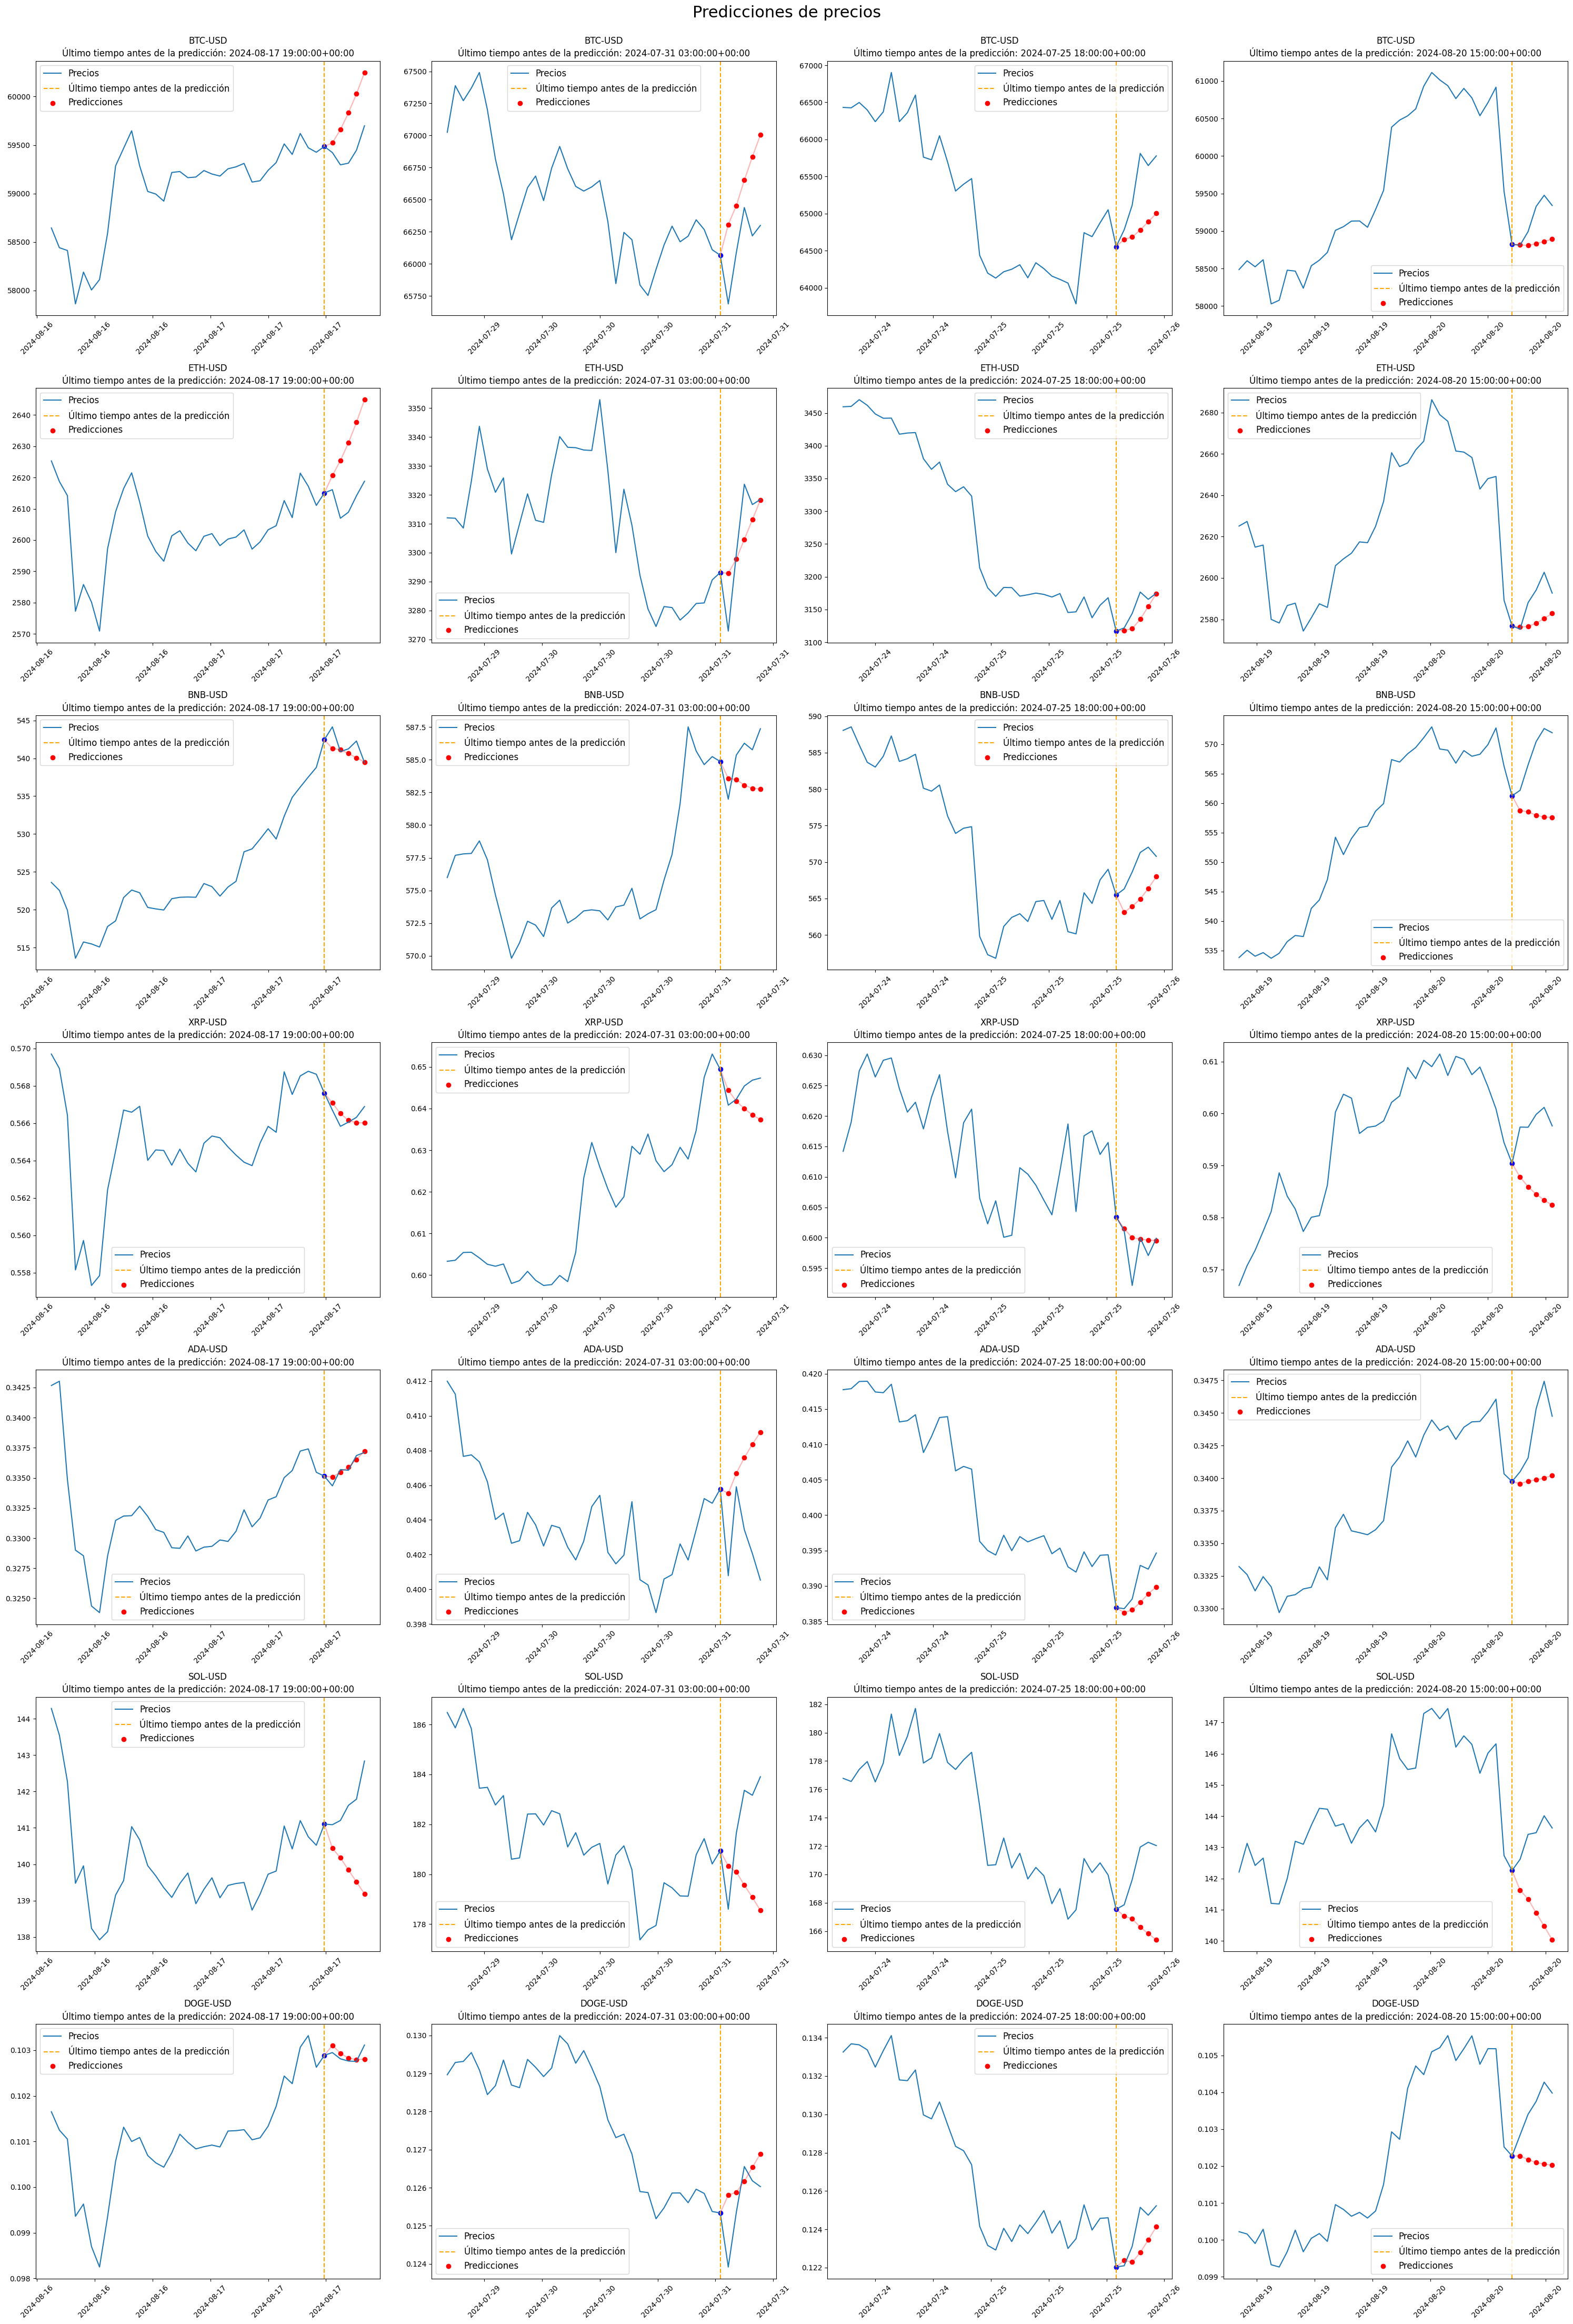

In [32]:
n_rows, n_cols = 7, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 45))

window_size = 40

fig.suptitle("Predicciones de precios", fontsize=22)

# Iterate over each subplot (i, j) to plot prices of i-th crypto and visually evaluate performance of prediction j
for j in range(n_cols):
    jth_time = index2timestamp(rand_ind[j], "test")
    jth_data = dataset_df.loc[
        jth_time + pd.Timedelta(hours=T-window_size) : jth_time + pd.Timedelta(hours=T-1)
    ] # from the window of size T starting at t, just consider the last window_size points
    pred_times = jth_data.index[-m:]
    last_time = jth_data.index[-m-1]
    
    for i in range(n_rows):
        ith_crypto = cryptos[i]
        last_price = dataset_df.loc[last_time][ith_crypto]
        
        axes[i, j].plot(jth_data[ith_crypto], label="Precios")
        axes[i, j].plot([last_time]+[t for t in pred_times], [last_price]+[pt for pt in pred_prices[rand_ind[j], :, i]], color="r", alpha=0.3)
        axes[i, j].axvline(last_time, color='orange', linestyle='--', label='Último tiempo antes de la predicción')
        axes[i, j].scatter(pred_times, pred_prices[rand_ind[j], :, i], color="r", label="Predicciones")
        axes[i, j].scatter([last_time], [last_price], color="b")
        axes[i, j].set_title(f"{ith_crypto}\nÚltimo tiempo antes de la predicción: {last_time}", fontsize=12)
        axes[i, j].xaxis.set_major_locator(plt.MaxNLocator(7))
        axes[i, j].tick_params(axis="x", labelrotation=45)
        axes[i,j ].legend(fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Resultados y conclusiones

Para tener una referencia ("baseline"), vamos a comparar los resultados obtenidos del Seq2Seq y Seq2Seq con atención con la predicción que consiste en mantener el último valor de la secuencia input constante en la secuencia de predicción, es decir, dada la secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ como input predecir la secuencia $(x_{t+\tau-1}, ..., x_{t+\tau-1})$ de tamaño $m$.

In [33]:
baseline = np.zeros(shape=y_test.shape)
for i in range(y_test.shape[0]):
    baseline[i] = np.array([X_test[i, -1, :] for _ in range(m)])

Error absoluto medio obtenido en cada serie de tiempo en la escala de la normalización:

In [34]:
# flatten predictions and targets
baseline_flat = baseline.reshape(-1, dim_vectors)

mae = mean_absolute_error(y_test_flat, baseline_flat, multioutput='raw_values')

print("Errores absolutos medios en la escala normalizada:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae[i])

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.3719613905868905
ETH-USD : 0.41436978088114385
BNB-USD : 0.3855326164885536
XRP-USD : 0.4234738652296728
ADA-USD : 0.3883744972801958
SOL-USD : 0.39049802079741025
DOGE-USD : 0.3790182375449475


Error en la escala de los precios:

In [35]:
baseline_prices = normalized_2_raw(baseline, means_test, stds_test)
baseline_prices_flat = baseline_prices.reshape(-1, dim_vectors)

mae_baseline = mean_absolute_error(y_prices_flat, baseline_prices_flat, multioutput='raw_values')

print("Errores absolutos medios en la escala de los precios:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_baseline[i])

Errores absolutos medios en la escala de los precios:
BTC-USD : 60831.396705892046
ETH-USD : 2793.314716310613
BNB-USD : 542.757918346678
XRP-USD : 1.3059304856867926
ADA-USD : 1.3740620654061608
SOL-USD : 149.61957088226123
DOGE-USD : 1.2369716871831888


### Comparación y conclusión

A continuación se muestra una tabla con el resumen de resultados en la escala de los precios:

In [42]:
pd.DataFrame.from_dict({
    "Baseline": mae_baseline,
    "Seq2Seq": mae_seq2seq,
    "Seq2Seq+Atención": mae_seq2seqattention,
    }, orient="index", columns=["BTC", "ETH", "BNB", "XRP", "ADA", "SOL", "DOGE"]
)

,BTC,ETH,BNB,XRP,ADA,SOL,DOGE
Baseline,60831.396706,2793.314716,542.757918,1.305930,1.374062,149.619571,1.236972
Seq2Seq,61179.404953,2806.261728,545.110190,1.307025,1.374053,150.928862,1.237025
Seq2Seq+Atención,61089.576690,2796.446252,539.636062,1.306552,1.374076,147.620620,1.237103


Cuando comparamos los errores de los modelos contra el baseline, podemos obtener si hay porcentaje de mejora o no con la siguiente fórmula: (error_modelo - error_baseline)/error_baseline*100. Si el porcentaje es negativo, significa que hubo una mejora (pues error_modelo < error_baseline). A continuación se muestra una tabla con dichos porcentajes:

In [43]:
pd.DataFrame.from_dict({
    "Seq2Seq": (mae_seq2seq-mae_baseline)/mae_baseline*100,
    "Seq2Seq+Atención": (mae_seq2seqattention-mae_baseline)/mae_baseline*100,
    }, orient="index", columns=["BTC", "ETH", "BNB", "XRP", "ADA", "SOL", "DOGE"]
)

,BTC,ETH,BNB,XRP,ADA,SOL,DOGE
Seq2Seq,0.572087,0.463500,0.433392,0.083788,-0.000663,0.875080,0.004290
Seq2Seq+Atención,0.424419,0.112108,-0.575184,0.047588,0.000980,-1.336022,0.010607


Podemos observar que en general, el Seq2Seq con atención obtuvo mejor desempeño que el Seq2Seq normal, teniendo mejor desempeño en 5 criptomonedas. Además, obtuvo mejoras con respecto al baseline en 2 criptomonedas, mientras que el Seq2Seq normal sólo tuvo una mejora con respecto al baseline en 1 criptomoneda.